In [1]:
import numpy as np

import matplotlib.pyplot as plt

this is the initialize boundary condition

In [2]:
# New init + neighbor
def initialize_spin_lattice(im_L, L):
    return np.random.choice([1, -1], size=(im_L, L))

In [3]:
def get_neighbors_2d(y, x, lattice_array):
    im_L,L = lattice_array.shape
    #print(lattice_array)
    #print(np.sum(lattice_array))
    up = ((y - 1) % im_L, x)
    down = ((y + 1) % im_L, x)
    left = (y, (x - 1) % L)
    right = (y, (x + 1) % L)
    return left, right, up, down

'''L =4
im_L = 4
lattice_array = initialize_spin_lattice(L, im_L)
get_neighbors_2d(0, 0, lattice_array)'''


'L =4\nim_L = 4\nlattice_array = initialize_spin_lattice(L, im_L)\nget_neighbors_2d(0, 0, lattice_array)'

link to empty metro

This is the linked boundary condition

In [5]:
# Function to get indexes of the neighbors in the lattice with periodic boundary conditions
def get_linked_neighbors(sub,y, x, lattice_array):
    im_L, L = lattice_array.shape
    if x >= sub:  # can change the subsystem size here
        if y == 0:
            up = (int(im_L/2-1), x)
            down = ((y + 1) % im_L, x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
        elif y == im_L/2-1:
            up = ((y - 1) % im_L, x)
            down = (0,x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
        elif y == im_L/2:
            up = (int(im_L-1), x)
            down = ((y + 1) % im_L, x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
        elif y == im_L-1:
            up = ((y - 1) % im_L, x)
            down = (int(im_L/2), x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
    
        else:                                                          
            return get_neighbors_2d(y, x, lattice_array)
    else:
        return get_neighbors_2d(y, x, lattice_array)
    



This is the indicator to check that whether half of the spins are the same

In [6]:
def check_spin(sub, lattice_array):
    im_L, L = lattice_array.shape
    check_lst = lattice_array[[0, int(im_L/2)], :int(sub)]
    #print(check_lst)
    #print(check_lst[0])
    return (check_lst == check_lst[0]).all()


In [7]:
def trans_mc_move_link(sub,lattice_array, h, delta_tau):
    im_L, L = lattice_array.shape
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_x = 1
    beta_cl = delta_tau
    J_y = gamma / beta_cl
    for i in range(0, im_L * L):
        x = np.random.randint(0, L)
        y = np.random.randint(0, im_L)
        spin_index = lattice_array[y, x]
        neighbor_x = 0
        neighbor_y = 0
        neighbors = get_linked_neighbors(sub,y, x,lattice_array)    # Get the horizontal and vertical neighbors using get_neighbors function
        #print(neighbors)
        for neighbor in neighbors[:2]:              # Sum the spins of the horizontal neighbors (left and right)
            neighbor_x += lattice_array[neighbor]
            
            
        deltaE_x = J_x * spin_index * neighbor_x   # Calculate the change in energy for the x interactions
        for neighbor in neighbors[2:]:      # Sum the spins of the vertical neighbors (up and down)
            neighbor_y += lattice_array[neighbor]
        deltaE_y = J_y * spin_index * neighbor_y   # Calculate the change in energy for the y interactions
        delta_E = 2 * (deltaE_x + deltaE_y)        # Total change in energy
        if delta_E <= 0 or (np.random.rand() < np.exp(-delta_E * beta_cl)):      # Metropolis condition
            # Flip the spin
            lattice_array[y, x] *= -1
    return lattice_array

'''L = 4 
im_L = 4
lattice_array = initialize_spin_lattice(L, im_L)
h =1 
delta_tau = 0.1
print(trans_mc_move_link(lattice_array, h, delta_tau))'''


'L = 4 \nim_L = 4\nlattice_array = initialize_spin_lattice(L, im_L)\nh =1 \ndelta_tau = 0.1\nprint(trans_mc_move_link(lattice_array, h, delta_tau))'

In [8]:
def Wolff_link(sub, lattice_array, h, delta_tau):
    from collections import deque
    
 

    im_L, L = lattice_array.shape
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_y = gamma / delta_tau
    J_x =1 

    # Calculate the probabilities outside the while loop
    ReL_Prob = 1 - np.exp(-2 * J_x * delta_tau)
    ImL_Prob = 1 - np.exp(-2 * np.abs(J_y) * delta_tau)

    # Choose a random site
    x = np.random.randint(0, L)
    y = np.random.randint(0, im_L)
    initial_spin = lattice_array[y, x]

    # Initialize the cluster and the frontier with the initial site
    cluster = {(y, x)}
    frontier = deque([(y, x)])

    while frontier:
        y, x = frontier.popleft()
        neighbors = get_linked_neighbors(sub, y, x, lattice_array)

        for i, neighbor in enumerate(neighbors):
            ny, nx = neighbor
            if lattice_array[ny, nx] == initial_spin and (ny, nx) not in cluster:
                # Use ReL_Prob for left-right neighbors, ImL_Prob for up-down neighbors
                if i< 2 and np.random.rand() < ReL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))
                elif i>= 2 and np.random.rand() < ImL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))

    # Flip the cluster
    for y, x in cluster:
        lattice_array[y, x] *= -1

    return lattice_array

In [9]:
def count_link(sub,lattice_array,N,h,delta_tau):
    im_L, L = lattice_array.shape
    count = 0


        
    for i in range(N):
        lattice_array = Wolff_link(sub,lattice_array,h,delta_tau)
        if check_spin(sub,lattice_array):
            count += 1
    return count

This is empty to link boundary condition

In [10]:
# Function to get indexes of the neighbors in the lattice with periodic boundary conditions
def get_dis_neighbors(y, x, lattice_array):
    im_L, L = lattice_array.shape
    if x >= 0:  # can change the subsystem size here
        if y == 0:
            up = (int(im_L/2-1), x)
            down = ((y + 1) % im_L, x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
        elif y == im_L/2-1:
            up = ((y - 1) % im_L, x)
            down = (0,x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
        elif y == im_L/2:
            up = (int(im_L-1), x)
            down = ((y + 1) % im_L, x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
        elif y == im_L-1:
            up = ((y - 1) % im_L, x)
            down = (int(im_L/2), x)
            left = (y, (x - 1) % L)
            right = (y, (x + 1) % L)
            return left, right, up, down
        
    
        else:                                                          
            return get_neighbors_2d(y, x, lattice_array)
    else:
        return get_neighbors_2d(y, x, lattice_array)

In [11]:
def trans_mc_move_dis(lattice_array, h, delta_tau):
    im_L,L = lattice_array.shape
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_x = 1
    beta_cl = delta_tau
    J_y = gamma / beta_cl
    for i in range(0, im_L * L):
        x = np.random.randint(0, L)
        y = np.random.randint(0, im_L)
        spin_index = lattice_array[y, x]
        neighbor_x = 0
        neighbor_y = 0
        neighbors = get_dis_neighbors(y, x,lattice_array)    # Get the horizontal and vertical neighbors using get_neighbors function
        #print(neighbors)
        for neighbor in neighbors[:2]:              # Sum the spins of the horizontal neighbors (left and right)
            neighbor_x += lattice_array[neighbor]
            
            
        deltaE_x = J_x * spin_index * neighbor_x   # Calculate the change in energy for the x interactions
        for neighbor in neighbors[2:]:      # Sum the spins of the vertical neighbors (up and down)
            neighbor_y += lattice_array[neighbor]
        deltaE_y = J_y * spin_index * neighbor_y   # Calculate the change in energy for the y interactions
        delta_E = 2 * (deltaE_x + deltaE_y)        # Total change in energy
        if delta_E <= 0 or (np.random.rand() < np.exp(-delta_E * beta_cl)):      # Metropolis condition
            # Flip the spin
            lattice_array[y, x] *= -1
    return lattice_array



In [12]:
def Wolff_dis(lattice_array, h, delta_tau):
    from collections import deque

    im_L, L = lattice_array.shape
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_y = gamma / delta_tau
    J_x = 1

    # Calculate the probabilities outside the while loop
    ReL_Prob = 1 - np.exp(-2 * J_x * delta_tau)
    ImL_Prob = 1 - np.exp(-2 * np.abs(J_y) * delta_tau)

    # Choose a random site
    x = np.random.randint(0, L)
    y = np.random.randint(0, im_L)
    initial_spin = lattice_array[y, x]

    # Initialize the cluster and the frontier with the initial site
    cluster = {(y, x)}
    frontier = deque([(y, x)])

    while frontier:
        y, x = frontier.popleft()
        neighbors = get_dis_neighbors(y, x, lattice_array)

        for i, neighbor in enumerate(neighbors):
            ny, nx = neighbor
            if lattice_array[ny, nx] == initial_spin and (ny, nx) not in cluster:
                # Use ReL_Prob for left-right neighbors, ImL_Prob for up-down neighbors
                if i< 2 and np.random.rand() < ReL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))
                elif i>= 2 and np.random.rand() < ImL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))

    # Flip the cluster
    for y, x in cluster:
        lattice_array[y, x] *= -1

    return lattice_array

In [13]:
def count_dis(sub,lattice_array,N,h,delta_tau):
    im_L,L = lattice_array.shape
    count = 0
    



    for i in range(N):
        lattice_array = Wolff_dis(lattice_array,h,delta_tau)
        if check_spin(sub,lattice_array):
            count += 1
    return count

In [14]:
def Wolff_dis(lattice_array, h, delta_tau):
    from collections import deque

    im_L, L = lattice_array.shape
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_x =1 
    J_y = gamma / delta_tau

    # Calculate the probabilities outside the while loop
    ReL_Prob = 1 - np.exp(-2 * J_x * delta_tau)
    ImL_Prob = 1 - np.exp(-2 * np.abs(J_y) * delta_tau)

    # Choose a random site
    x = np.random.randint(0, L)
    y = np.random.randint(0, im_L)
    initial_spin = lattice_array[y, x]

    # Initialize the cluster and the frontier with the initial site
    cluster = {(y, x)}
    frontier = deque([(y, x)])

    while frontier:
        y, x = frontier.popleft()
        neighbors = get_dis_neighbors(y, x, lattice_array)

        for i, neighbor in enumerate(neighbors):
            ny, nx = neighbor
            if lattice_array[ny, nx] == initial_spin and (ny, nx) not in cluster:
                # Use ReL_Prob for left-right neighbors, ImL_Prob for up-down neighbors
                if i< 2 and np.random.rand() < ReL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))
                elif i>= 2 and np.random.rand() < ImL_Prob:
                    cluster.add((ny, nx))
                    frontier.append((ny, nx))

    # Flip the cluster
    for y, x in cluster:
        lattice_array[y, x] *= -1

    return lattice_array

In [15]:
def test(sub,lattice_array,N,h,delta_tau):
    im_L,L = lattice_array.shape
    text_link = []
    text_dis = []
    
    for i in range(10000):
        lattice_array = Wolff_link(sub,lattice_array,h,delta_tau)
    
    for i in range(10000):
        lattice_array = Wolff_dis(lattice_array,h,delta_tau)
    
    
    for k in range(10):
        text_link.append(count_link(sub,lattice_array,N,h,delta_tau))
    e = np.mean(text_link)
    y = np.std(text_link)

    for j in range(10):
        text_dis.append(count_dis(sub,lattice_array,N,h,delta_tau))
    g = np.mean(text_dis)
    z = np.std(text_dis)
    
    Entropy = -np.log(g/e)
    
    delta_Entropy = np.sqrt(np.abs((y/e)-(z/g)))
    
    return Entropy, float(delta_Entropy/np.sqrt(10))

In [ ]:
L = 8
im_L = 80
lattice_array = initialize_spin_lattice(im_L,L)
N = 10000
h = 1
delta_tau = 0.1
sub = [1,2,3,4]
colors = ['r', 'g', 'b','c'] 

for i in range(4):
    Entropy, delta_Entropy = test(sub[i],lattice_array,N,h,delta_tau)
    plt.errorbar(sub[i], Entropy, yerr=delta_Entropy, fmt='o', color = colors[i], label = 'subsystem size = %i' %sub[i])
    file = open("Entropy.txt","a")
    file.write("\n %i x %i Entropy: %f, delta_Entropy: %f" %(L,im_L,Entropy,delta_Entropy))
    file.close()



#file = open("Entropy.txt","a")
#file.write("\n6x60 Entropy: 0.5465857046969573, delta_Entropy: 0.5684080935289485")
#file.close()
#print(test(sub,lattice_array,N,h,delta_tau))

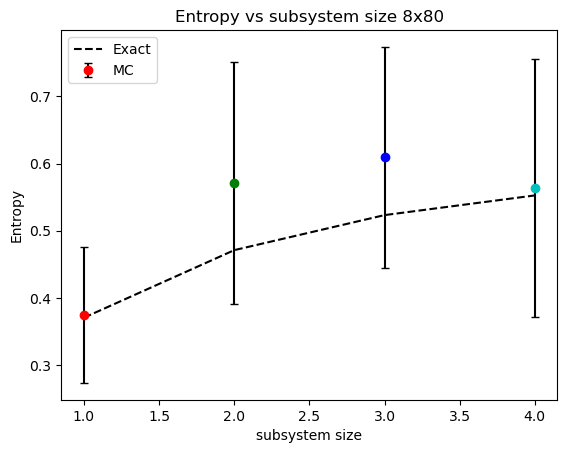

In [ ]:
test = [0.3741387526290906,0.5710020817687932,0.609343008554051,0.5636907827428765]
error = [0.3191978150150242,0.5687875647507932,0.5198315932922077,0.6069925885507542]
sample = [0.3704,0.4710,0.5232,0.5525]
error_1 = np.array(error)
sub = [1,2,3,4]
colors = ['r', 'g', 'b','c'] 

for i in range(4):
     plt.errorbar(sub[i], test[i], yerr=error_1[i]/np.sqrt(10), fmt='o', color=colors[i], ecolor='black', capsize=3)

plt.plot(sub,sample,'k--')

plt.xlabel('subsystem size')
plt.ylabel('Entropy')
plt.legend(['Exact','MC'])
plt.title('Entropy vs subsystem size 8x80')

plt.show()

try the system size
4 x 40, 6 x 60
testing:e/g

test the value of hc = 1

change the system size 
keep the h 
4x8 4x16 4x24

change the subsystem size 12 x 24 
1,2,3,4,5,6

In [ ]:
L = 8
im_L = 80
lattice_array = initialize_spin_lattice(im_L,L)
N = 20000
h = 1
delta_tau = 0.1
sub = [L/2-3,L/2-2,L/2-1,L/2]

e = []
t = []
colors = ['r', 'g', 'b','c'] 

for i in range(4):
    e.append(test(sub[i],lattice_array,N,h,delta_tau)[0])
    t.append(test(sub[i],lattice_array,N,h,delta_tau)[1])
    plt.errorbar(sub[i], e[i], yerr=t[i]/np.sqrt(100), fmt='o', color=colors[i], ecolor='black', capsize=3) # there is 10 mean 

plt.xlabel('Subsystem size')
plt.ylabel('Entropy')

plt.show()




test the energy 

In [ ]:
def energy(L,im_L,h,delta_tau):
    gamma = -0.5 * np.log(np.tanh(delta_tau * h))
    J_x = 1
    beta_cl = delta_tau
    J_y = gamma / beta_cl
    
    lattice_array = initialize_spin_lattice(L, im_L)
    print(lattice_array)
    energy = 0
    neighbor_x = 0
    neighbor_y = 0

    for i in range(L):
        for j in range(im_L):
            neighbor_x = 0
            neighbor_y = 0
                 
            spin_number = lattice_array[i,j]
            neighbors = get_neighbors_2d(i,j,lattice_array)
            print(neighbors)
                
            for neighbor in neighbors[:2]: 
                print(lattice_array[neighbor])
                neighbor_x += lattice_array[neighbor]
                #print(neighbor_x)
            energy_x = J_x*spin_number*neighbor_x  
            #print(energy_x)
                        
            for neighbor in neighbors[2:]:                     
                neighbor_y += lattice_array[neighbor[0],neighbor[1]]
            #print(neighbor_y)
            energy_y = J_y * spin_number * neighbor_y
            #print(energy_y)
                
            energy += energy_x + energy_y
            
                
    return float(-energy)/(L*im_L)
            
            
L = 4
im_L = 4
h = 1
delta_tau = 0.1



print(energy(L,im_L,h,delta_tau)) 
    
    
    
    

[[ 1 -1 -1  1]
 [-1 -1  1 -1]
 [-1 -1  1  1]
 [-1 -1 -1  1]]
((0, 3), (0, 1), (3, 0), (1, 0))
1
-1
((0, 0), (0, 2), (3, 1), (1, 1))
1
-1
((0, 1), (0, 3), (3, 2), (1, 2))
-1
1
((0, 2), (0, 0), (3, 3), (1, 3))
-1
1
((1, 3), (1, 1), (0, 0), (2, 0))
-1
-1
((1, 0), (1, 2), (0, 1), (2, 1))
-1
1
((1, 1), (1, 3), (0, 2), (2, 2))
-1
-1
((1, 2), (1, 0), (0, 3), (2, 3))
1
-1
((2, 3), (2, 1), (1, 0), (3, 0))
1
-1
((2, 0), (2, 2), (1, 1), (3, 1))
-1
1
((2, 1), (2, 3), (1, 2), (3, 2))
-1
1
((2, 2), (2, 0), (1, 3), (3, 3))
1
-1
((3, 3), (3, 1), (2, 0), (0, 0))
1
-1
((3, 0), (3, 2), (2, 1), (0, 1))
-1
-1
((3, 1), (3, 3), (2, 2), (0, 2))
-1
1
((3, 2), (3, 0), (2, 3), (0, 3))
-1
-1
-5.764776675880279


In [ ]:
L = 4
im_L = 4
h = 1
delta_tau = 0.1



print(energy(L,im_L,h,delta_tau))



    


[[ 1  1 -1 -1]
 [ 1 -1  1  1]
 [-1 -1 -1  1]
 [-1 -1 -1  1]]
((0, 3), (0, 1), (3, 0), (1, 0))
-1
1
((0, 0), (0, 2), (3, 1), (1, 1))
1
-1
((0, 1), (0, 3), (3, 2), (1, 2))
1
-1
((0, 2), (0, 0), (3, 3), (1, 3))
-1
1
((1, 3), (1, 1), (0, 0), (2, 0))
1
-1
((1, 0), (1, 2), (0, 1), (2, 1))
1
1
((1, 1), (1, 3), (0, 2), (2, 2))
-1
1
((1, 2), (1, 0), (0, 3), (2, 3))
1
1
((2, 3), (2, 1), (1, 0), (3, 0))
1
-1
((2, 0), (2, 2), (1, 1), (3, 1))
-1
-1
((2, 1), (2, 3), (1, 2), (3, 2))
-1
1
((2, 2), (2, 0), (1, 3), (3, 3))
-1
-1
((3, 3), (3, 1), (2, 0), (0, 0))
1
-1
((3, 0), (3, 2), (2, 1), (0, 1))
-1
-1
((3, 1), (3, 3), (2, 2), (0, 2))
-1
1
((3, 2), (3, 0), (2, 3), (0, 3))
-1
-1
4.440892098500626e-16


We try to calculate the magnetization of 1-D transverse field Ising model

In [ ]:
def trans_1d_m(L,im_L,lattice_array):

    N_time_im_L = L*im_L
    M = np.sum(lattice_array)
    
    return 1/N_time_im_L * np.abs(M)
    
    

In [ ]:
def run_M(L,im_L, h, delta_tau,N):
    lattice_array = initialize_spin_lattice(L, im_L)
    expect = []
    avg_expect = [] 
    s_d = []
    temp = []
    
    for i in range(10000):
        lattice_array = trans_mc_move_link(lattice_array, h, delta_tau)
        
    for i in range(N):
        lattice_array = trans_mc_move_link(lattice_array, h, delta_tau)
        temp.append(trans_1d_m(L,im_L,lattice_array))
        
        if (i%100==0) and (i!=0):
            expect.append(np.mean(temp))
        
    
    avg_expect.append(np.mean(expect))
    s_d.append(np.std(expect))
        
  
        
       
    return avg_expect
    
